In [3]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, Lambda
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
import numpy as np
from Bio import SeqIO
from numpy import array
from numpy import argmax
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle
from keras.layers import Embedding
from keras import backend as K
from keras.backend import expand_dims
import matplotlib.pyplot as plt
from keras.regularizers import l1, l2
from sklearn.metrics import roc_curve, auc, classification_report
import tensorflow as tf

train_x = []
train_y = []
r_test_x = []
r_test_y = []
posit_1 = 1
negat_0 = 0
win_size = 33 # actual window size
win_size_kernel = int(win_size/2 + 1)


# define universe of possible input values
alphabet = 'ARNDCQEGHILKMFPSTWYV-'

# define a mapping of chars to integers
char_to_int = dict((c, i) for i, c in enumerate(alphabet))
int_to_char = dict((i, c) for i, c in enumerate(alphabet))

# TRAIN DATASET -------------------------------------------------------------
#for positive sequence
def inner1():
    #Input
    data = seq_record.seq
    #rint(data) 
    # integer encode input data
    for char in data:
        if char not in alphabet:
            return
    integer_encoded = [char_to_int[char] for char in data]
    train_x.append(integer_encoded)
    train_y.append(posit_1)
for seq_record in SeqIO.parse("../data/train/fasta/positive_sites.fasta", "fasta"): # training data positive
    inner1()
#for negative sequence
def inner2():
    #Input
    data = seq_record.seq
    #print(data) 
    # integer encode input data
    for char in data:
        if char not in alphabet:
            return
    integer_encoded = [char_to_int[char] for char in data]
    train_x.append(integer_encoded)
    train_y.append(negat_0)
for seq_record in SeqIO.parse("../data/train/fasta/negative_sites.fasta", "fasta"): # training data negative
    inner2()
# Changing to array (matrix)    
train_x = np.array(train_x)
train_y = array(train_y)


#-------------------------TEST DATASET----------------------------------------
#for positive sequence
def innertest1():
    #Input
    data = seq_record.seq
    #rint(data) 
    # integer encode input data
    for char in data:
        if char not in alphabet:
            return
    integer_encoded = [char_to_int[char] for char in data]
    r_test_x.append(integer_encoded)
    r_test_y.append(posit_1)
for seq_record in SeqIO.parse("../data/test/fasta/test_positive_sites.fasta", "fasta"): # test positive
    innertest1()
#for negative sequence
def innertest2():
    #Input
    data = seq_record.seq
    #print(data) 
    # integer encode input data
    for char in data:
        if char not in alphabet:
            return
    integer_encoded = [char_to_int[char] for char in data]
    r_test_x.append(integer_encoded)
    r_test_y.append(negat_0)
for seq_record in SeqIO.parse("../data/test/fasta/test_negative_sites.fasta", "fasta"): # test negative
    innertest2()
# Changing to array (matrix)    
r_test_x = array(r_test_x)
r_test_y = array(r_test_y)



# Balancing test dataset
# Testing Data Balancing by undersampling####################################
rus = RandomUnderSampler(random_state=7)
x_res3, y_res3 = rus.fit_resample(r_test_x, r_test_y)
#Shuffling
r_test_x, r_test_y = shuffle(x_res3, y_res3, random_state=7)
r_test_x = np.array(r_test_x)
r_test_y = np.array(r_test_y)
############################################################################


#-----------------------------------------------------------------------------#
#################CNN#####################################
epochs = 100
num_classes = 2
batch_size = 256
optimize_2 = tf.keras.optimizers.Adam()

loss_2 = tf.keras.losses.binary_crossentropy



test_size = 0.2
seed = 3
x_train, x_test, y_train, y_test = train_test_split(train_x, train_y, test_size=test_size,
random_state=seed)

# Training Data Balancing by undersampling####################################

# for idx,a in enumerate(x_train):
#     if len(a) != 49:
#         print(idx)

# import sys
# sys.exit(0)

rus = RandomUnderSampler(random_state=7)
x_res, y_res = rus.fit_resample(x_train, y_train)
#Shuffling
x_train, y_train = shuffle(x_res, y_res, random_state=7)
# x_train = np.array(x_train)
# y_train = np.array(y_train)
##############################################################################


# Testing Data Balancing by undersampling####################################

rus = RandomUnderSampler(random_state=7)
x_res1, y_res1 = rus.fit_resample(x_test, y_test)
#Shuffling
x_test, y_test = shuffle(x_res1, y_res1, random_state=7)
x_test = np.array(x_test)
y_test = np.array(y_test)
############################################################################

train_size = len(x_train)
test_size = len(x_test)


# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [4]:
y_train.shape

(7590, 2)

In [5]:
y_test.shape

(1890, 2)

In [7]:
model = Sequential()
model.add(Embedding(batch_size, 21, input_length=win_size))
print(model.output_shape)
model.add(Lambda(lambda x: K.expand_dims(x, 3)))
print(model.output_shape)
model.add(Conv2D(64, kernel_size=(win_size_kernel, 3), activation = 'relu', kernel_initializer='he_normal', padding = 'VALID'))
#model.add(BatchNormalization())
print(model.input_shape)
model.add(Dropout(0.6))
#model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation = 'relu', kernel_initializer='he_normal', padding = 'SAME'))
#model.add(BatchNormalization())
model.add(Dropout(0.6))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Conv2D(256, (3, 3), activation = 'relu', kernel_initializer='he_normal', padding = 'SAME'))
#model.add(BatchNormalization())
#model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(768, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=loss_2,
              optimizer=optimize_2,
              metrics=['accuracy'])

metric = 'val_accuracy'
checkpointer = ModelCheckpoint(filepath="../models/st_model_best.h5", 
                               monitor = metric,
                               verbose=0, 
                               save_weights_only=False,
                               save_best_only=True)

print("This is initial ",model.layers[0].get_weights()[0][16])
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          callbacks=[checkpointer],
          validation_data=(x_test, y_test))


(None, 33, 21)
(None, 33, 21, 1)
(None, 33)
This is initial  [-0.01265105  0.00986918 -0.03990734  0.04082979 -0.01868922  0.02742683
 -0.01682843  0.00826962  0.00109258 -0.03490883  0.00992227  0.02070886
 -0.00872982  0.02459791 -0.02052392 -0.04337264  0.0482755   0.04301215
 -0.04087337  0.02439065 -0.03276793]
Epoch 1/100
30/30 [==============================] - 11s 341ms/step - loss: 0.7185 - accuracy: 0.5072 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/100
30/30 [==============================] - 9s 291ms/step - loss: 0.6932 - accuracy: 0.5016 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/100
30/30 [==============================] - 9s 286ms/step - loss: 0.6931 - accuracy: 0.4966 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/100
30/30 [==============================] - 9s 301ms/step - loss: 0.6930 - accuracy: 0.5195 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/100
30/30 [==============================] - 10s 327ms/step - loss: 0.6932 - accuracy: 0.5032 - val_l

In [8]:
#model
model = Sequential()
model.add(Embedding(64, 21, input_length=win_size))
print(model.output_shape)
model.add(Lambda(lambda x: K.expand_dims(x, 3)))
print(model.output_shape)
model.add(Conv2D(64, kernel_size=(win_size_kernel, 1), activation = 'relu', kernel_initializer='he_normal', padding = 'VALID'))
#model.add(BatchNormalization())
print(model.input_shape)
model.add(Dropout(0.8))
#model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 1), activation = 'relu', kernel_initializer='he_normal', padding = 'SAME'))
#model.add(BatchNormalization())
model.add(Dropout(0.8))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Conv2D(256, (3, 3), activation = 'relu', kernel_initializer='he_normal', padding = 'SAME'))
#model.add(BatchNormalization())
#model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_normal', name = 'dense_1_niraj'))
model.add(Dropout(0.7))
model.add(Dense(64, activation='relu', kernel_initializer='he_normal', name = 'dense_2_niraj'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

(None, 33, 21)
(None, 33, 21, 1)
(None, 33)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 33, 21)            1344      
                                                                 
 lambda_2 (Lambda)           (None, 33, 21, 1)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 17, 21, 64)        1152      
                                                                 
 dropout_8 (Dropout)         (None, 17, 21, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 17, 21, 128)       24704     
                                                                 
 dropout_9 (Dropout)         (None, 17, 21, 128)       0         
                                                                 
 max_pooli

In [16]:
model.compile(loss=loss_2,
              optimizer=optimize_2,
              metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=5, mode='auto')

metric = 'val_accuracy'
checkpointer = ModelCheckpoint(filepath="../models/st_model_best_2.h5", 
                               monitor = metric,
                               verbose=0, 
                               save_weights_only=False,
                               save_best_only=True)

print("This is initial ",model.layers[0].get_weights()[0][16])
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          callbacks=[checkpointer],
          validation_data=(x_test, y_test))

#Embedding output
print("This is final ",model.layers[0].get_weights()[0][16])


This is initial  [ 0.05745008  0.02449046  0.00930628  0.05945331  0.00159209 -0.04463813
 -0.00536031  0.02919056 -0.01020031  0.08259946  0.04839333  0.00108911
  0.00608035  0.01656623 -0.02386559 -0.02252843  0.03049041  0.02363473
 -0.04242041  0.01774971 -0.01148582]
Epoch 1/100
30/30 [==============================] - 8s 256ms/step - loss: 0.5358 - accuracy: 0.7335 - val_loss: 0.5981 - val_accuracy: 0.7259
Epoch 2/100
30/30 [==============================] - 6s 193ms/step - loss: 0.5395 - accuracy: 0.7295 - val_loss: 0.5956 - val_accuracy: 0.7190
Epoch 3/100
30/30 [==============================] - 6s 190ms/step - loss: 0.5420 - accuracy: 0.7335 - val_loss: 0.6011 - val_accuracy: 0.7196
Epoch 4/100
30/30 [==============================] - 6s 193ms/step - loss: 0.5353 - accuracy: 0.7378 - val_loss: 0.6048 - val_accuracy: 0.7233
Epoch 5/100
30/30 [==============================] - 6s 194ms/step - loss: 0.5362 - accuracy: 0.7394 - val_loss: 0.6007 - val_accuracy: 0.7196
Epoch 6/100

In [17]:
model.layers[0].get_weights()[0][21]

array([-0.01827589,  0.03563502,  0.00705605,  0.02777215, -0.02475202,
        0.03548988, -0.00535332,  0.04943037,  0.04046658,  0.01137948,
        0.04881759, -0.04528818, -0.01175619, -0.02118206, -0.04363128,
       -0.03347109,  0.0079033 , -0.01645175, -0.00955043, -0.02085294,
       -0.00858042], dtype=float32)

Test loss: 0.5846683979034424
Test accuracy: 0.7193675637245178
Matthews Correlation :  0.45161894876420067
Confusion Matrix : 
 [[152 101]
 [ 41 212]]
AUC :  0.7193675889328064
              precision    recall  f1-score   support

           0       0.79      0.60      0.68       253
           1       0.68      0.84      0.75       253

    accuracy                           0.72       506
   macro avg       0.73      0.72      0.72       506
weighted avg       0.73      0.72      0.72       506



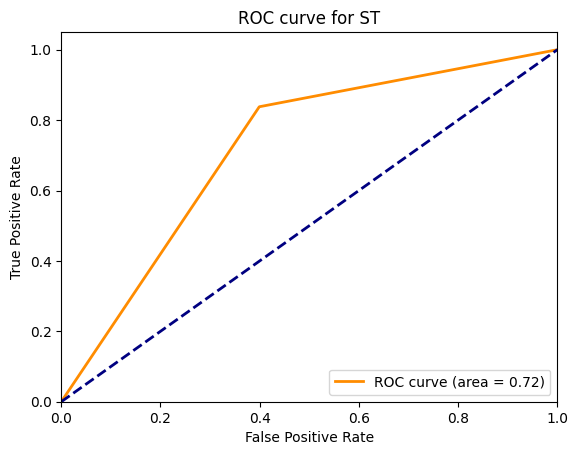

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 33, 21)            1344      
                                                                 
 lambda_2 (Lambda)           (None, 33, 21, 1)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 17, 21, 64)        1152      
                                                                 
 dropout_8 (Dropout)         (None, 17, 21, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 17, 21, 128)       24704     
                                                                 
 dropout_9 (Dropout)         (None, 17, 21, 128)       0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 10, 128)      

In [18]:
r_test_y_2 = tf.keras.utils.to_categorical(r_test_y, num_classes)
score = model.evaluate(r_test_x, r_test_y_2, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import confusion_matrix
Y_pred = model.predict(r_test_x)
Y_pred = (Y_pred > 0.5)
y_pred1 = [np.argmax(y, axis=None, out=None) for y in Y_pred]
y_pred1 = np.array(y_pred1)

print("Matthews Correlation : ",matthews_corrcoef(r_test_y, y_pred1))
print("Confusion Matrix : \n",confusion_matrix(r_test_y, y_pred1))
# ROC

fpr, tpr, _ = roc_curve(r_test_y, y_pred1)
roc_auc = auc(fpr, tpr)
print("AUC : ", roc_auc)
print(classification_report(r_test_y, y_pred1))

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for ST')
plt.legend(loc="lower right")
plt.show()

print(model.summary())
# Save model
model.save('../models/embedding_model.h5')


In [19]:
def plot(history):
    # learning curves of model accuracy
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='test_acc')
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='test_loss')
    plt.legend()
    plt.show()

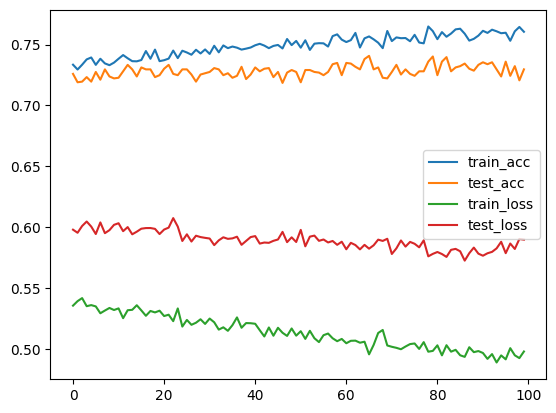

In [21]:
plot(history)